In [3]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

In [79]:
def extract_scores(f, task=None):
    entailment_dict = {
        'None' : 0,
        'Entailment': 1,
        'Paraphrase': 2
    }
    f_tree = ET.parse(f)
    f_root = f_tree.getroot()
    f_list = []
    for pair in f_root.iter('pair'):
        try:
            found_score = float(pair.get(task))
        except:
            found_score = float(entailment_dict[pair.get(task)])
        f_list.append(found_score)
    return f_list

def generate_scores_df(f1=None, f2=None, f1_label='f1_label', f2_label='f2_label', task=None):
    f1_list = np.array(extract_scores(f1, task))
    f2_list = np.array(extract_scores(f2, task))
    f2_list = f1_list - f2_list
    f2_list = np.array([ x**2 for x in f2_list ])
    f1_list = np.round(f1_list)
    df = pd.DataFrame({f1_label: f1_list, f2_label: f2_list})
    df = df.groupby(f1_label).mean().reset_index().sort_values(f1_label)
    df = df[[f2_label]]
#     df = df.sort_values(by=[f1_label, f2_label], ascending=[True, False])
#     df = df.reset_index()
#     df['idx'] = df.index
#     df = pd.melt(df, id_vars=['idx'], value_vars=[f1_label, f2_label])
    return df
    
def get_dataplot(dataplot, value_rename, idx_rename, variable_rename, num_samples=500):
#     dataplot = dataplot.sample(num_samples)
    dataplot = dataplot.rename(columns={
        "value" : value_rename,
        "idx": idx_rename,
        "variable": variable_rename
    })
    return dataplot

In [80]:
def generate_grid(model_file, task_name, plot_title):
    def generate_section(test_file, submission_file, dataset_name, plot_title):
        dataplot = generate_scores_df(test_file, 
                           submission_file, 
                           task=task_name,
                           f1_label="Gold scores",
                           f2_label="Average absolute error")

        value_rename = "Gold scores vs. absolute error"
        idx_rename = "sentence pair"
        variable_rename = "model"

        dataplot = get_dataplot(dataplot, value_rename, idx_rename, variable_rename)

        dataplot['dataset'] = dataset_name
        dataplot['score'] = dataplot.index + 1
        dataplot['model'] = plot_title
        return dataplot

    test_file = './assin2-test.xml'
    submission_file = './samples/{0}.xml'.format(model_file)
    task_name = 'similarity'
    dataset_name = "ASSIN 2"
    dataplot = generate_section(test_file, submission_file, dataset_name, plot_title)


#     test_file = './sources/assin-ptbr-test.xml'
#     submission_file = './generated_submissions/assin1ptbr/{0}.xml'.format(model_file)
#     task_name = 'similarity'
#     dataset_name = "ASSIN 1 (PT-BR)"
#     df = generate_section(test_file, submission_file, dataset_name, plot_title)
#     dataplot = dataplot.append(df)

#     test_file = './sources/assin2-test.xml'
#     submission_file = './generated_submissions/assin2-trainonly/{0}.xml'.format(model_file)
#     task_name = 'similarity'
#     dataset_name = "ASSIN 2"
#     df = generate_section(test_file, submission_file, dataset_name, plot_title)
#     dataplot = dataplot.append(df)


    return dataplot
#     g = sns.FacetGrid(dataplot, col="dataset", legend_out=True)
#     g.fig.subplots_adjust(top=0.5)
#     g.fig.suptitle(plot_title, fontsize=16)
#     return g.map(sns.barplot, "score", "Average absolute error")



model_file = "roberta"
task_name = 'similarity'
plot_title = "RoBERTa"
dataplot = generate_grid(model_file, task_name, plot_title)

model_file = "bert"
task_name = 'similarity'
plot_title = "BERT-multilingual"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

model_file = "5fold_stacking"
task_name = 'similarity'
plot_title = "Ensemble ( stacking, 5-fold )"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

model_file = "average"
task_name = 'similarity'
plot_title = "Ensemble ( averaging )"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

dataplot

,Average absolute error,dataset,score,model
0,1.413047,ASSIN 2,1,RoBERTa
1,2.391685,ASSIN 2,2,RoBERTa
2,1.058928,ASSIN 2,3,RoBERTa
3,0.426405,ASSIN 2,4,RoBERTa
4,0.089732,ASSIN 2,5,RoBERTa
0,6.265721,ASSIN 2,1,BERT-multilingual
1,3.696093,ASSIN 2,2,BERT-multilingual
2,1.358086,ASSIN 2,3,BERT-multilingual
3,0.383777,ASSIN 2,4,BERT-multilingual
4,0.032836,ASSIN 2,5,BERT-multilingual


Text(0, 0.5, 'Mean squared error')

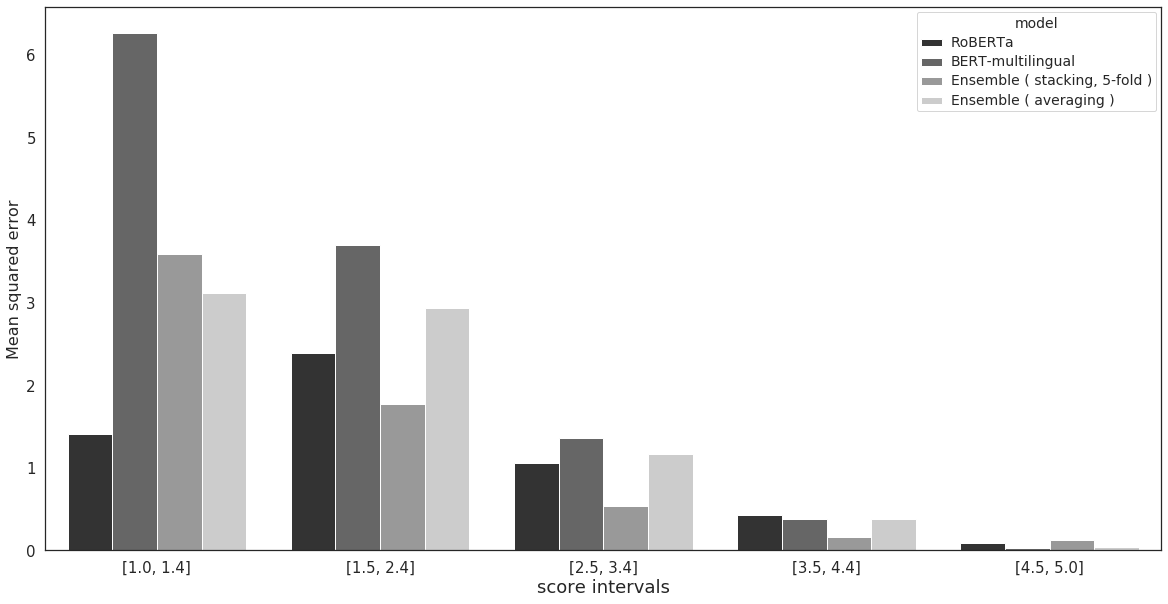

In [81]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# sns.set(font_scale=0.95)
# g = sns.FacetGrid(dataplot, row="dataset", col="model", margin_titles=True, palette="gray")
# g.map(sns.lineplot, x="score", y="Average absolute error", hue="model");
dataplot = dataplot.rename(columns={
    "Average absolute error" : "Mean squared error",
    "score": "score range"
})
# g = sns.FacetGrid(dataplot, col="dataset", hue="model", margin_titles=True, legend_out=True)
# g.map(sns.lineplot, "score", "Mean squared error")
# g.add_legend()
# g.fig.subplots_adjust(top=0.8)
# g.fig.suptitle('Semantic similarity: Mean squared error on each score range', fontsize=14)

sns.set_style("white")
g = sns.barplot( x="score range", y="Mean squared error", hue="model", data=dataplot, palette='gray')

g.set(xticklabels=['[1.0, 1.4]', '[1.5, 2.4]', '[2.5, 3.4]', '[3.5, 4.4]', '[4.5, 5.0]'])

ax = g
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

plt.xlabel('score intervals', fontsize=18)
plt.ylabel('Mean squared error', fontsize=16)

Text(0, 0.5, 'Pearson correlation')

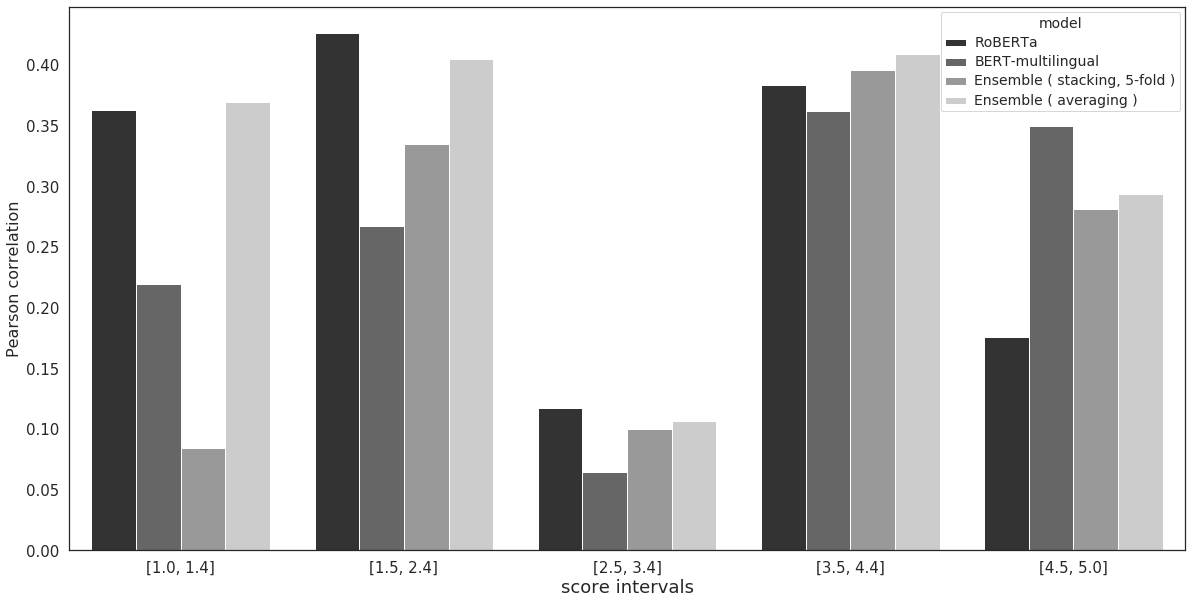

In [77]:
from collections import defaultdict
from scipy.stats import pearsonr
def generate_scores_df(f1=None, f2=None, f1_label='f1_label', f2_label='f2_label', task=None):
    f1_list = np.array(extract_scores(f1, task))
    f2_list = np.array(extract_scores(f2, task))
    df_dct = defaultdict(list)
    for idx, item in enumerate(f1_list):
        df_dct[round(item)].append({'gold': item, 'pred': f2_list[idx]})
    for key, value in df_dct.items():
        new_df = pd.DataFrame(df_dct[key])
        gold = new_df['gold'].values.tolist()
        pred = new_df['pred'].values.tolist()
        goal = pearsonr(gold, pred)[0]
        df_dct[key] = goal
    keys = []
    values = []
    for key, value in dict(df_dct).items():
        keys.append(key)
        values.append(value)
    return pd.DataFrame({'score': keys, 'pearson': values}).sort_values('score')

def generate_grid(model_file, task_name, plot_title):
    def generate_section(test_file, submission_file, dataset_name, plot_title):
        dataplot = generate_scores_df(test_file, 
                           submission_file, 
                           task=task_name,
                           f1_label="Gold scores",
                           f2_label="Average absolute error")

#         value_rename = "Gold scores vs. absolute error"
#         idx_rename = "sentence pair"
#         variable_rename = "model"

#         dataplot = get_dataplot(dataplot, value_rename, idx_rename, variable_rename)

#         dataplot['dataset'] = dataset_name
#         dataplot['score'] = dataplot.index + 1
        dataplot['model'] = plot_title
        return dataplot

    test_file = './assin2-test.xml'
    submission_file = './samples/{0}.xml'.format(model_file)
    task_name = 'similarity'
    dataset_name = "ASSIN 2"
    dataplot = generate_section(test_file, submission_file, dataset_name, plot_title)
    return dataplot

model_file = "roberta"
task_name = 'similarity'
plot_title = "RoBERTa"
dataplot = generate_grid(model_file, task_name, plot_title)

model_file = "bert"
task_name = 'similarity'
plot_title = "BERT-multilingual"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

model_file = "5fold_stacking"
task_name = 'similarity'
plot_title = "Ensemble ( stacking, 5-fold )"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

model_file = "average"
task_name = 'similarity'
plot_title = "Ensemble ( averaging )"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

dataplot

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
dataplot = dataplot.rename(
    columns={
        "score": "score range"
    }
)
sns.set_style("white")
g = sns.barplot( x="score range", y="pearson", hue="model", data=dataplot, palette='gray')

g.set(xticklabels=['[1.0, 1.4]', '[1.5, 2.4]', '[2.5, 3.4]', '[3.5, 4.4]', '[4.5, 5.0]'])

ax = g
plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

plt.xlabel('score intervals', fontsize=18)
plt.ylabel('Pearson correlation', fontsize=16)

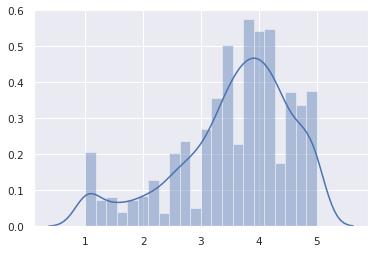

In [233]:


sns.distplot(extract_scores('./sources/assin2-test.xml', task="similarity"))

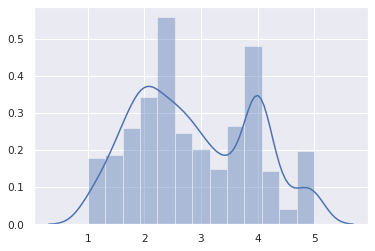

In [236]:
sns.distplot(extract_scores('./sources/assin-ptpt-test.xml', task="similarity"))

In [147]:
def generate_final_plot(selected_dataset_name, top_param=1):
    dataplot_section = dataplot[dataplot['dataset']==selected_dataset_name]
    # Draw a nested barplot to show survival for class and sex
    g = sns.catplot(x="score", y="Average absolute error", hue="model", data=dataplot_section,
                    height=6, kind="bar", palette="gray")
    g.despine(left=True)
    g.fig.subplots_adjust(top=top_param)
    g.fig.suptitle(selected_dataset_name, fontsize=16)

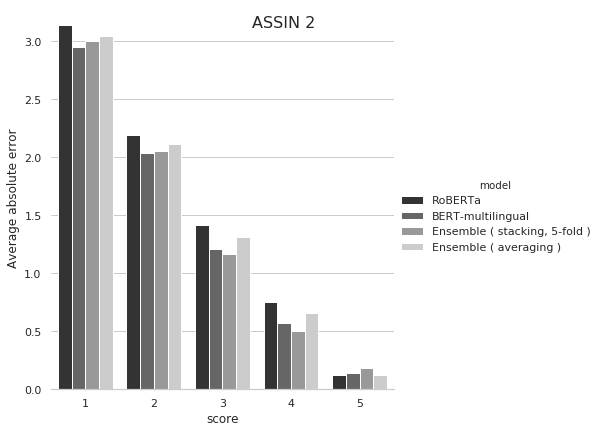

In [148]:
generate_final_plot("ASSIN 2")

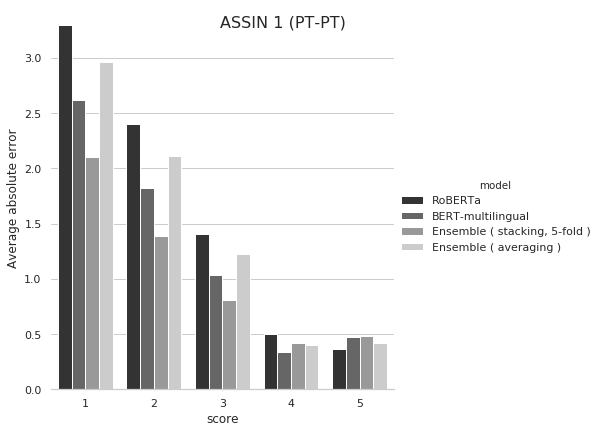

In [149]:
generate_final_plot("ASSIN 1 (PT-PT)")

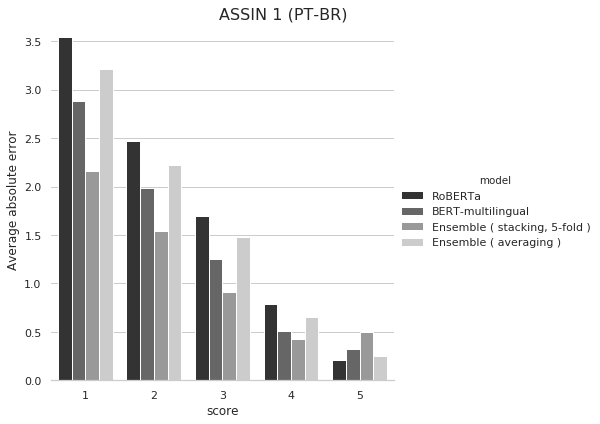

In [150]:
generate_final_plot("ASSIN 1 (PT-BR)", top_param=0.95)

In [1]:
def extract_scores(f):
    f_tree = ET.parse(f)
    f_root = f_tree.getroot()
    f_list = []
    for pair in f_root.iter('pair'):
        found_score = pair.get('entailment')
        f_list.append(found_score)
    return f_list

def generate_scores_df(f1=None, f2=None, f1_label='f1_label', f2_label='f2_label'):
    f1_list = np.array(extract_scores(f1))
    f2_list = np.array(extract_scores(f2))
    df = pd.DataFrame({f1_label: f1_list, f2_label: f2_list})
    return df
    
def get_dataplot(dataplot, value_rename, idx_rename, variable_rename, num_samples=500):
#     dataplot = dataplot.sample(num_samples)
    dataplot = dataplot.rename(columns={
        "value" : value_rename,
        "idx": idx_rename,
        "variable": variable_rename
    })
    return dataplot

def generate_grid(model_file, task_name, plot_title):
    def generate_section(test_file, submission_file, dataset_name, plot_title):
        dataplot = generate_scores_df(test_file, 
                           submission_file,
                           f1_label="Gold",
                           f2_label="Prediction")

        value_rename = "Gold scores vs. absolute error"
        idx_rename = "sentence pair"
        variable_rename = "model"

        dataplot = get_dataplot(dataplot, value_rename, idx_rename, variable_rename)

        dataplot['dataset'] = dataset_name
        dataplot['model'] = plot_title
        return dataplot

    test_file = './sources/assin-ptpt-test.xml'
    submission_file = './generated_submissions/assin1ptpt/{0}.xml'.format(model_file)
    task_name = 'similarity'
    dataset_name = "ASSIN 1 (PT-PT)"
    dataplot = generate_section(test_file, submission_file, dataset_name, plot_title)


    test_file = './sources/assin-ptbr-test.xml'
    submission_file = './generated_submissions/assin1ptbr/{0}.xml'.format(model_file)
    task_name = 'similarity'
    dataset_name = "ASSIN 1 (PT-BR)"
    df = generate_section(test_file, submission_file, dataset_name, plot_title)
    dataplot = dataplot.append(df)

    test_file = './sources/assin2-test.xml'
    submission_file = './generated_submissions/assin2-trainonly/{0}.xml'.format(model_file)
    task_name = 'similarity'
    dataset_name = "ASSIN 2"
    df = generate_section(test_file, submission_file, dataset_name, plot_title)
    dataplot = dataplot.append(df)


    return dataplot
#     g = sns.FacetGrid(dataplot, col="dataset", legend_out=True)
#     g.fig.subplots_adjust(top=0.5)
#     g.fig.suptitle(plot_title, fontsize=16)
#     return g.map(sns.barplot, "score", "Average absolute error")



model_file = "submission-roberta"
task_name = 'similarity'
plot_title = "RoBERTa"
dataplot = generate_grid(model_file, task_name, plot_title)

model_file = "submission-bert"
task_name = 'similarity'
plot_title = "BERT-multilingual"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

model_file = "final_submission_5folds"
task_name = 'similarity'
plot_title = "Ensemble ( stacking, 5-fold )"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

model_file = "submission-average"
task_name = 'similarity'
plot_title = "Ensemble ( averaging )"
df = generate_grid(model_file, task_name, plot_title)
dataplot = dataplot.append(df)

dataplot.head()

NameError: name 'np' is not defined

In [12]:

from sklearn.metrics import confusion_matrix

test_file = './sources/assin2-test.xml'
submission_file = './samples/5fold_stacking.xml'
df = generate_scores_df(test_file, submission_file)
y_true = df['f1_label']
y_pred = df['f2_label']

cm = confusion_matrix(y_true, y_pred)
cm

array([[1150,   74],
       [ 212, 1012]])

In [13]:
test_file = './sources/assin2-test.xml'
submission_file = './samples/roberta.xml'
df = generate_scores_df(test_file, submission_file)
y_true = df['f1_label']
y_pred = df['f2_label']

cm = confusion_matrix(y_true, y_pred)
cm

array([[1146,   78],
       [ 206, 1018]])

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

def generate_confusion_matrix(selected_dataset_name, model_name, top_param=1):
    dataplot_section = dataplot[dataplot['dataset']==selected_dataset_name]
    dataplot_section = dataplot_section[dataplot_section['model']==model_name]
    y_true = dataplot_section['Gold'].values.tolist()
    y_pred = dataplot_section['Prediction'].values.tolist()
    return y_true, y_pred
    
y_test, y_pred = generate_confusion_matrix("ASSIN 2", "RoBERTa")

matthews_corrcoef(y_test, y_pred) 

NameError: name 'dataplot' is not defined

In [181]:
y_test, y_pred = generate_confusion_matrix("ASSIN 2", "BERT-multilingual")

dataplot[['model']].drop_duplicates()

# matthews_corrcoef(y_test, y_pred) 

,model
0,RoBERTa
0,BERT-multilingual
0,"Ensemble ( stacking, 5-fold )"
0,Ensemble ( averaging )


In [182]:
y_test, y_pred = generate_confusion_matrix("ASSIN 2", "BERT-multilingual")
matthews_corrcoef(y_test, y_pred) 

0.6768082082637692

In [183]:
y_test, y_pred = generate_confusion_matrix("ASSIN 2", "RoBERTa")
matthews_corrcoef(y_test, y_pred) 

0.6176862005394158

In [184]:
y_test, y_pred = generate_confusion_matrix("ASSIN 2", "Ensemble ( stacking, 5-fold )")
matthews_corrcoef(y_test, y_pred) 

0.6814411489887574

In [185]:
y_test, y_pred = generate_confusion_matrix("ASSIN 2", "Ensemble ( averaging )")
matthews_corrcoef(y_test, y_pred) 

0.6650452777706922

In [186]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-PT)", "BERT-multilingual")
matthews_corrcoef(y_test, y_pred) 

0.49873527588790795

In [187]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-PT)", "RoBERTa")
matthews_corrcoef(y_test, y_pred) 

0.5443964599436409

In [188]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-PT)", "Ensemble ( stacking, 5-fold )")
matthews_corrcoef(y_test, y_pred) 

0.44127159553853895

In [189]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-PT)", "Ensemble ( averaging )")
matthews_corrcoef(y_test, y_pred) 

0.5341730551087349

In [190]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-BR)", "BERT-multilingual")
matthews_corrcoef(y_test, y_pred) 

0.5132934398999935

In [191]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-BR)", "RoBERTa")
matthews_corrcoef(y_test, y_pred) 

0.4728002024365028

In [192]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-BR)", "Ensemble ( stacking, 5-fold )")
matthews_corrcoef(y_test, y_pred) 

0.42635840877292863

In [193]:
y_test, y_pred = generate_confusion_matrix("ASSIN 1 (PT-BR)", "Ensemble ( averaging )")
matthews_corrcoef(y_test, y_pred) 

0.5156201427699509